## 1- Importing libraries

also doing some logistics

In [0]:
!pip install Sastrawi

In [0]:
#Load all the needed libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import os
import json
from pprint import pprint
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import datetime as dt
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.linear_model import SGDClassifier
import pickle
from time import monotonic
from datetime import timedelta
import sklearn.metrics as metrics
import sys
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from time import time

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
plt.style.use('seaborn-ticks')

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2- Loading Train/test data

In [0]:
path = '/content/drive/My Drive/GitHub/nsdc_beginner/Data'

#path = './Data'
dftrain = pd.read_csv(os.path.join(path, 'train.csv'))
dftest = pd.read_csv(os.path.join(path, 'test.csv'))


In [0]:
with open(os.path.join(path,'categories.json')) as f:
    categories = json.load(f)

pprint(categories)

{'Beauty': {'BB & CC Cream': 5,
            'Blush On': 2,
            'Bronzer': 11,
            'Concealer': 7,
            'Contour': 6,
            'Face Palette': 0,
            'Foundation': 1,
            'Highlighter': 8,
            'Lip Gloss': 14,
            'Lip Liner': 15,
            'Lip Tint': 13,
            'Lipstick': 12,
            'Other Face Cosmetics': 4,
            'Other Lip Cosmetics': 16,
            'Powder': 3,
            'Primer': 9,
            'Setting Spray': 10},
 'Fashion': {'A Line Dress': 21,
             'Big Size Dress': 24,
             'Big Size Top': 30,
             'Blouse': 26,
             'Bodycon Dress': 22,
             'Casual Dress': 18,
             'Crop Top': 29,
             'Maxi Dress': 20,
             'Others': 17,
             'Party Dress': 19,
             'Shirt': 27,
             'Tanktop': 28,
             'Tshirt': 25,
             'Wedding Dress': 23},
 'Mobile': {'Advan': 45,
            'Alcatel': 55,
            

## 3- Feature Engineering

### 3.1 Divide the training data into Big categories containers (Beauty/Fashion/Mobile)

In [0]:
# 1. add a new col that contins the big category (beauty, fashion, mobile)

newCol = dftrain.image_path.apply(lambda x : x.split('_')[0])
dftrain['mainCat'] = newCol
# dftrain.head()

Check for unique values

In [0]:
set(dftrain['mainCat'])

{'beauty', 'fashion', 'mobile'}

### 3.2 Display the total number of samples under each category

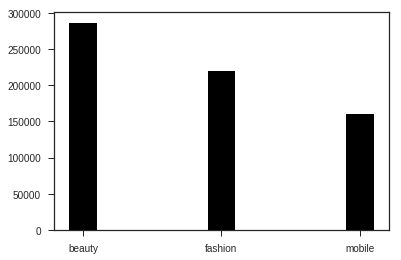

In [0]:
Beautydf= dftrain[dftrain['mainCat'] == 'beauty']
Fashiondf= dftrain[dftrain['mainCat'] == 'fashion']
Mobiledf= dftrain[dftrain['mainCat'] == 'mobile']

plt.bar(['beauty', 'fashion', 'mobile'],[Beautydf.shape[0],Fashiondf.shape[0],Mobiledf.shape[0]],width=0.2, color='black');

#### 3.2.1 EDA

In [0]:
Fashiondf.head()

,itemid,title,Category,image_path,mainCat
286583,2282553,retro floral dress,17,fashion_image/78d17fdb159bba51a4250dc3d583245e,fashion
286584,13822218,dress floral sifon,18,fashion_image/2f77dac9965bbfdb03cbd3724b3552c5,fashion
286585,33555935,korean white chiffon collar dress,18,fashion_image/6dbe2e7cba5ddbb750d2144d8f248f11,fashion
286586,65755120,women s trendy apricot o neck solid chiffon bl...,19,fashion_image/dc9b21429604148fc0342d12694f3294,fashion
286587,65857438,big sale baju gamis pesta india aysilla pancar...,20,fashion_image/6c25c578dd8edce742a805f891f1a51f,fashion


In [0]:
Fashiondf.shape

(219702, 5)

### 3.3 Randomize the train-dataset

To avoid bias in the training dataset, it is a good practice

In [0]:
Beautydf.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            286573, 286574, 286575, 286576, 286577, 286578, 286579, 286580,
            286581, 286582],
           dtype='int64', length=286583)

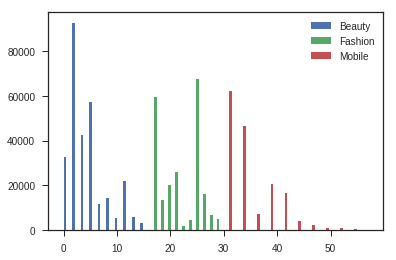

In [0]:
# randomize datasets

Beautydf = Beautydf.reindex(np.random.permutation(Beautydf.index))
Fashiondf = Fashiondf.reindex(np.random.permutation(Fashiondf.index))
Mobiledf = Mobiledf.reindex(np.random.permutation(Mobiledf.index))

# Beautydf.Category.hist(width = 0.5)
# Fashiondf.Category.hist(width = 0.5)
# Mobiledf.Category.hist(width = 0.5)

fig, catAx = plt.subplots(1, 1)

catAx.hist(Beautydf.Category, label='Beauty', width=0.5)
catAx.hist(Fashiondf.Category, label='Fashion', width=0.5)
catAx.hist(Mobiledf.Category , label='Mobile', width=0.5)

catAx.legend()
plt.show()

### 3.4 Remove any number with more than 3 digits in the dataset

For example : `02854323232` which could be an id or something


In [0]:
# Remove any number in the dataset with more than or equal to 3 digits. 

Beautydf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Fashiondf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)
Mobiledf.title.replace(r'\b[0-9]{3,}\b', '', regex=True)

546923           discount fastival luna g8 bets electronics
628136     beli 1 gratis samsung galaxy a8  blue resmi sein
513593    ready stock micro sd v gen 8gb microsd hc vgen...
587712                                                himax
660939                                       ori bm vivo v7
509177             lg q6 3 32 garansi resmi indonesia hitam
555139    promo asus rog gl552vx i7 7700hq 12gb 1tb gtx9...
522653    handphone bm black market super promo beli 2 g...
608583    converter adapter lightning to jack iphone 7 8...
519121                            sony xperia z4 au z3 plus
538395                                   iphone 6 64gb grey
546300    diskon 50 xiomi redmi s2 4 64 promo terbatas s...
522852    promo akbar piala dunia samsung s7 edge 32gb s...
537782           promo samsung galaxy alpha garansi 1 tahun
532553    wa  beli 2 bonus 1 minat serius chat  gratis i...
548322                                         vivo v11 pro
536877                      oppo a57 2nd

In [0]:
Fashiondf['Category'].value_counts()

18    56598
25    33922
26    33845
20    19978
27    16199
22    15225
19    13493
21    10483
28     6493
24     4251
29     3338
17     2765
23     1671
30     1441
Name: Category, dtype: int64

#### 3.5.1 Check the phrase of the length

#### 3.8 Remove the top common words across all categories which may not be helping with the classification

## 4- Cross Validation

### 4.1 Split the training dataset into train/test

In [0]:
B_X_train = Beautydf.title
B_y_train = Beautydf.Category

F_X_train = Fashiondf.title
F_y_train = Fashiondf.Category

M_X_train = Mobiledf.title
M_y_train = Mobiledf.Category

In [0]:
def tokenize_data(vect, X_train, X_test):
    ''' Tokenize the training and test set'''
    # create document-term matrices using the vectorizer
    X_train_dtm = vect.fit_transform(X_train)
    X_test_dtm = vect.transform(X_test)

    # print the number of features that were generated
    #print('Features: ', X_train_dtm.shape[1])
    
    return X_train_dtm, X_test_dtm

In [0]:
def trainCV(X_train, y_train, vect, folds = 3, random_state=42, 
            clf=SGDClassifier(random_state=42, max_iter=5000, tol=1e-3, 
                              loss='hinge', verbose=1)):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)

    skfolds = StratifiedKFold(n_splits=folds, random_state=random_state)

    cv_start_time = monotonic()
    
    scores = []
    features = []
    for train_index, test_index in skfolds.split(X_train, y_train):
        start_time = monotonic()
        
        clone_clf = clone(clf)
        #X_train_folds = X_train[train_index]
        y_train_folds = y_train.iloc[train_index]
        #X_test_fold = X_train[test_index]
        y_test_fold = y_train.iloc[test_index]
        
        X_train_folds,X_test_fold = tokenize_data(vect, 
                                                  X_train.iloc[train_index], 
                                                  X_train.iloc[test_index])
        features.append(X_train_folds.shape[1])
        
        print ("{} Starting the training ".format(dt.datetime.now()))
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        print ("{} Completed the training ".format(dt.datetime.now()))

        n_correct = sum(y_pred == y_test_fold)
        scores.append(n_correct / len(y_pred))
        
        end_time = monotonic()
        print("{} Training time per fold: {}".format(dt.datetime.now(),
                                       timedelta(seconds=end_time - start_time)))

        
    print ("Features: {}".format(features))
    print("Features variance: %0.2f (+/- %0.2f)" % (np.mean(features), 
                                                    np.std(features) * 2))
    print ("Scores: {}".format(scores))
    print("Accuracy: %0.5f (+/- %0.5f)" % (np.mean(scores), 
                                           np.std(scores) * 2))
    
    cv_end_time = monotonic()
    print("Total Training time: {}".format(timedelta(seconds=cv_end_time - cv_start_time)))
    
    return clone_clf, scores, features

### 4.2 Defining Stop words

In [0]:
factory = StopWordRemoverFactory()
id_stopwords = factory.get_stop_words()
en_stopwords  = list(stopwords.words('english'))
stopwords = id_stopwords + en_stopwords
stopwords[1:20]

['untuk',
 'pada',
 'ke',
 'para',
 'namun',
 'menurut',
 'antara',
 'dia',
 'dua',
 'ia',
 'seperti',
 'jika',
 'jika',
 'sehingga',
 'kembali',
 'dan',
 'tidak',
 'ini',
 'karena']

### 4.3 Model Training for Beauty

#### 4.3.1 Optiming for nrange

Optimal hyperparam is at nrange 1,8 with Accuracy: 0.78536 (+/- 0.00335)

With slight improvement seen using One vs Rest with Accuracy: 0.78557 (+/- 0.00376)

And with stop words Accuracy: 0.78435 (+/- 0.00327)

* Features: [2060519, 2059314, 2055361, 2059141, 2059118]
* Features variance: 2058690.60 (+/- 3487.51)
* Scores: [0.7866127034523664, 0.787446355674959, 0.7855958965053998, 0.784320910106086, 0.7857579088799316]
* Accuracy: 0.78595 (+/- 0.00210)
* Total Training time: 0:04:07.240765

2019-03-21 05:41:18.444888 Training time per fold: 1:09:01.194346

Features: [500000, 500000]

Features variance: 500000.00 (+/- 0.00)

Scores: [0.7542185995226597, 0.7548590610584204]

Accuracy: 0.75454 (+/- 0.00064)

Total Training time: 2:30:41.566123

#### 4.4.2 Training for Optimal Model for Mobile

Optimal hyperparam for Mobile is with nrange of 1,5 with Accuracy: 0.82828 (+/- 0.00265)

Using One vs Rest is seeing slight improvement with Accuracy: 0.82856 (+/- 0.00143).

And with stop words: Accuracy: 0.82006 (+/- 0.00239).

* Features: [1030842, 1029869, 1029107, 1030184, 1027609]
* Features variance: 1029522.20 (+/- 2215.01)
* Scores: [0.8285375814446488, 0.8311040438998535, 0.8259784812100421, 0.8314981752394024, 0.8282692787621662]
* Accuracy: 0.82908 (+/- 0.00405)
* Total Training time: 0:02:20.155520



### 4.5 Model Training for Fashion

#### 4.5.1 Optiming for the nrange for Fashion

Optimal for Fashion is Ngram range of 1,14 with Accuracy: 0.64612 (+/- 0.00261)

And using One vs Rest with Accuracy: 0.64587 (+/- 0.00192).

With stop words with Accuracy: 0.64569 (+/- 0.00502).

Using RandomizedGridSearch with SGD
* Features: [2574193, 2573700, 2572438, 2571429, 2575672]
* Features variance: 2573486.40 (+/- 2919.42)
* Scores: [0.6499567651208301, 0.6513210295155087, 0.6532929771061854, 0.6549754187909687, 0.6576988733356094]
* Accuracy: 0.65345 (+/- 0.00545)
* Total Training time: 0:04:32.68714

Using Logistic Regression: content/drive/My Drive/GitHub/nsdc_beginner/ModelLogR_F201903202347
* Training time per fold: 1:14:58.622968
* Features: [50000, 50000, 50000, 50000, 50000]
* Features variance: 50000.00 (+/- 0.00)
* Scores: [0.6173258089473445, 0.624695628427736, 0.620294934231487, 0.6225873998543335, 0.6203482417207238]
* Accuracy: 0.62105 (+/- 0.00495)
* Total Training time: 7:17:53.833652

#### 4.5.2 Find Optimal Model for Fashion

RandomizedSearchCV took 3123.99 seconds for 3 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.573 (std: 0.000)
Parameters: {'solver': 'lbfgs', 'C': 100}

Model with rank: 2
Mean validation score: 0.573 (std: 0.000)
Parameters: {'solver': 'sag', 'C': 100}

Model with rank: 3
Mean validation score: 0.568 (std: 0.001)
Parameters: {'solver': 'sag', 'C': 0.01}

Best score 0.5728683733118323

Best estimator

      LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=2, warm_start=False)

2019-03-21 06:42:15.947567 Training time per fold: 1:43:06.952375

Features: [500000, 500000]

Features variance: 500000.00 (+/- 0.00)

Scores: [0.593522429362074, 0.5952606376199406]

Accuracy: 0.59439 (+/- 0.00174)

Total Training time: 3:34:55.249190

Best count vectorizer param appears to be at min df =1, max df = 0.6 and max features at 100,000.

#### 4.5.5 Testing stemming next

### 1.0 Fashion Optimization

In [0]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [0]:
F_vect = CountVectorizer(ngram_range=(1,6), analyzer='word', 
                         max_features=100000)
Ftest_vect = CountVectorizer(ngram_range=(1,6), analyzer='word',
                         max_features=1000)


In [0]:
Mtest_vect = CountVectorizer(ngram_range=(1,5),analyzer='word',
                          max_features=1000)
M_vect = CountVectorizer(ngram_range=(1,5), analyzer='word',
                         max_features=100000)

In [0]:
B_vect = CountVectorizer(ngram_range=(1,8), analyzer='word',
                         max_features=100000)
Btest_vect = CountVectorizer(ngram_range=(1,8), analyzer='word',
                             max_features=1000)

In [0]:
def randomSearch(X, y, vect):
  X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                               test_size=0.33, random_state=42)
  n_iter_search = 1

  X_train_dtm, X_test_dtm = tokenize_data(vect, X_train, X_test)
  
  model = LogisticRegression(penalty="l2", max_iter=50000, 
                             multi_class='multinomial')

  params = {
    "C" : [0.001,0.01,0.1,1,10,100],
    #"penalty" : ["l2", "l1"],
     "solver": ["newton-cg"] #, "sag", "saga", "lbfgs"]
  }
  
  clf = RandomizedSearchCV(model, 
                         param_distributions=params, 
                         cv=1,
                   scoring='accuracy',
                   error_score='raise',
                   verbose =2,
                   n_jobs=-1,
                   n_iter=n_iter_search,
                  #loss="hinge",
                  #penalty="l2"
                  )
  
  start = time()

  clf.fit(X_train_dtm, y_train)

  print("RandomizedSearchCV took %.2f seconds for %d candidates"
        " parameter settings." % ((time() - start), n_iter_search))
  report(clf.cv_results_)
  
  return clf

def printBestScore(clf):
  print("Best score {}".format(clf.best_score_))
  print("Best estimator {}".format(clf.best_estimator_))

In [0]:
X_train, X_test, y_train, y_test = train_test_split(F_X_train, F_y_train, 
                                               test_size=0.3, random_state=42)

In [0]:
X_train.head()

439488    blus sexy model off shoulder kerah halter moti...
392937    dress mini skinny sexy lengan panjang crew nec...
366671      korean women slim thin plaid long sleeved dress
370689    gaun pesta tanpa lengan dengan hiasan pita dan...
318709    dress wanita sexy model off shoulder untuk mus...
Name: title, dtype: object

BOW with KERAS

In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

Using TensorFlow backend.


In [0]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(X_train) # only fit on train
x_train = tokenize.texts_to_matrix(X_train)
x_test = tokenize.texts_to_matrix(X_test)

In [0]:
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (153791, 1000)
x_test shape: (65911, 1000)
y_train shape: (153791, 31)
y_test shape: (65911, 31)


In [0]:
batch_size = 64
epochs = 30

In [0]:
from keras import optimizers
from keras.layers import LeakyReLU


# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.add(Activation('relu')) #'relu'))
#model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 138411 samples, validate on 15380 samples
Epoch 1/30
138411/138411 [==============================] - 12s 86us/step - loss: 2.0454 - acc: 0.3203 - val_loss: 1.9599 - val_acc: 0.3413
Epoch 2/30
138411/138411 [==============================] - 11s 82us/step - loss: 1.9810 - acc: 0.3401 - val_loss: 1.9376 - val_acc: 0.3528
Epoch 3/30
138411/138411 [==============================] - 11s 82us/step - loss: 1.9622 - acc: 0.3467 - val_loss: 1.9262 - val_acc: 0.3549
Epoch 4/30
102912/138411 [=====================>........] - ETA: 2s - loss: 1.9505 - acc: 0.3504

KeyboardInterrupt: ignored

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

with default:

Test accuracy: 0.6328078772863587

with momentum nesterov

Test accuracy: 0.6246605270572061

with elu

Test accuracy: 0.603556310773679

with leaky relu

Test accuracy: 0.6293638391281404

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

nb = Pipeline([('vect', F_vect),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

In [0]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Linear support next

In [0]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', F_vect),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, 
                                      random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

In [0]:
%%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

Word2Vec

In [0]:
!pip install gensim

In [0]:
%%time
import gensim
from gensim.models import Word2Vec

gnews_vect = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz'
wv = gensim.models.KeyedVectors.load_word2vec_format(gnews_vect, binary=True)
wv.init_sims(replace=True)

Running using the best model

With 1000 features
* Training time per fold: 0:14:10.745222
* Features: [1000, 1000, 1000, 1000, 1000]
* Features variance: 1000.00 (+/- 0.00)
* Scores: [0.5821917808219178, 0.5859863914616662, 0.5845432615720723, 0.5829843408594318, 0.5824741094799135]
* Accuracy: 0.58364 (+/- 0.00286)
* Total Training time: 1:11:50.006892

* Best score 0.5771924234838189
* Best estimator 
          LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=2, warm_start=False)

In [0]:
#F_bestModel = F_clf.best_estimator_
F_bestModel = LogisticRegression(C=100, class_weight=None, dual=False, 
                                 fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=2, warm_start=False)

In [0]:
F5_vect = CountVectorizer(ngram_range=(1,6), analyzer='word', 
                         max_features=500000)

In [0]:
Fo_logr, Fo_scores, Fo_features = trainCV(F_X_train, F_y_train, vect=F5_vect, 
                                         clf=F_bestModel, folds=2)

50000 features this time

Save the model

In [0]:
# Save Model Using Pickle


if True:
  model_path = "/content/drive/My Drive/GitHub/nsdc_beginner/ModelLogR_F5_{}".format(dt.datetime.today().strftime('%Y%m%d%H%M'))
  if (not os.path.exists(model_path)):
    os.mkdir(model_path)

  # save the model to disk
  filename = 'finalized_model.sav'
  pickle.dump(Fo_logr, open(os.path.join(model_path,filename), 'wb'))

  # save the vectorizer as well
  v_filename = "vector.pkl"
  pickle.dump(F5_vect, open(os.path.join(model_path,v_filename), "wb"))

  print ("Save the model the vectorizer to disk")


Reload the model and vocabulary

In [0]:
# load the model from disk
F_Logr = pickle.load(open(os.path.join(model_path,filename), 'rb'))
F_Logr

In [0]:
F_vec = pickle.load(open(os.path.join(model_path,v_filename), "rb"))
F_vec

### 2.0 For Beauty

with 1000 features

RandomizedSearchCV took 2464.68 seconds for 3 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.738 (std: 0.000)
Parameters: {'solver': 'newton-cg', 'C': 10}

Model with rank: 2
Mean validation score: 0.737 (std: 0.001)
Parameters: {'solver': 'newton-cg', 'C': 0.1}

Model with rank: 3
Mean validation score: 0.737 (std: 0.000)
Parameters: {'solver': 'sag', 'C': 100}

Best score 0.7376226272132717
Best estimator LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=2, warm_start=False)

In [0]:
B_vect = CountVectorizer(ngram_range=(1,8))
Bs_vect = CountVectorizer(ngram_range=(1,8), stop_words=stopwords)

In [0]:
B_clf = randomSearch(B_X_train, B_y_train, Bs_vect)

In [0]:
printBestScore(B_clf)

In [0]:
B_bestModel = B_clf.best_estimator_

In [0]:
Bo_sgd, Bo_scores, Bo_features = trainCV(B_X_train, B_y_train, vect=Bs_vect, 
                                         clf=B_bestModel)

### 3.0 For Mobile

RandomizedSearchCV took 1617.47 seconds for 3 candidates parameter settings.

Model with rank: 1
Mean validation score: 0.781 (std: 0.000)
Parameters: {'solver': 'newton-cg', 'C': 10}

Model with rank: 2
Mean validation score: 0.754 (std: 0.000)
Parameters: {'solver': 'sag', 'C': 0.01}

Model with rank: 3
Mean validation score: 0.697 (std: 0.001)
Parameters: {'solver': 'saga', 'C': 0.001}

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=2, warm_start=False)

2019-03-21 02:41:10.123337 Training time per fold: 0:04:34.997758

Features: [100000, 100000]

Features variance: 100000.00 (+/- 0.00)

Scores: [0.8110140950480229, 0.8097305389221557]

Accuracy: 0.81037 (+/- 0.00128)

Total Training time: 0:10:04.989215

In [0]:
Ms_vect = CountVectorizer(ngram_range=(1,5), stop_words=stopwords)
M_vect = CountVectorizer(ngram_range=(1,5))

In [0]:
M_clf = randomSearch(M_X_train, M_y_train, Ms_vect)

In [0]:
printBestScore(M_clf)

In [0]:
M_bestModel = M_clf.best_estimator_

In [0]:
Mo_sgd, Mo_scores, Mo_features = trainCV(M_X_train, M_y_train, vect=Ms_vect, 
                                         clf=M_bestModel)

### 4.6 Checking the scores

#### 4.6.1 Summary:
---
 

1.   **Beauty Category**:    `ngram_range(1, 8) OVR`
---
2.   **Fashion Category**:    `ngram_range(1, 14) OVR`
---
3.   **Mobile Category**:    `ngram_range(1,5) OVR`
---

In [0]:
total_scores = Bo_scores+ Fo_scores+ Mo_scores
print("OvO with stopwords Accuracy: %0.5f (+/- %0.5f)" % (np.mean(total_scores), 
                                       np.std(total_scores) * 2))

#### 4.5.1 Result comparison:
* OvO with stopwords Accuracy: 0.75610 (+/- 0.15001)
* OvO without stopwords Accuracy: 0.75598 (+/- 0.15262)
* OvR with stopwords Accuracy: 0.75615 (+/- 0.14967)

Your submission scored 0.76247, which is not an improvement of your best score. Keep trying!


## 5- Modelling

1. Divide the test dataset into 3 Categories
2. Remove numbers more than 3 Digits from the test dataset.
3. Train + Predict.


### 5.1 Divide the test dataset into 3 Categories

In [0]:
#add category col
newTestCol = dftest.image_path.apply(lambda x: x.split('_')[0])
dftest['newCat'] = newTestCol

In [0]:
dftest.tail()

In [0]:
MobileTest = dftest[dftest['newCat'] == 'mobile']
BeautyTest = dftest[dftest['newCat'] == 'beauty']
FashionTest = dftest[dftest['newCat'] == 'fashion']

fig, axt = plt.subplots(1,1)
axt.bar(['beauty', 'fashion', 'mobile'], [len(BeautyTest), len(FashionTest), len(MobileTest)], width=0.5)


### 5.3 Prediction Dataset

In [0]:
B_X_test = BeautyTest.title
F_X_test = FashionTest.title
M_X_test = MobileTest.title

### 5.4 Prediction Function

In [0]:
def modelPredict(X_train, y_train, X_test, vect, 
                 clf=SGDClassifier(random_state=42,max_iter=5000, 
                                            tol=1e-3,loss='hinge')):
    ''' Train a classifier using CV'''
    #clf = SGDClassifier(random_state=random_state)
    
    X_train_dtm,X_test_dtm = tokenize_data(vect, X_train, X_test)
    clf.fit(X_train_dtm, y_train)
    y_pred = clf.predict(X_test_dtm)
    return y_pred

In [0]:
B_y_pred = modelPredict(B_X_train, B_y_train, B_X_test, Bs_vect, clf=B_bestModel)

In [0]:
F_y_pred = modelPredict(F_X_train, F_y_train, F_X_test, F5_vect, clf=Fo_logr)

In [0]:
M_y_pred = modelPredict(M_X_train, M_y_train, M_X_test, Ms_vect, clf=M_bestModel)

### 5.5 Run Prediction

In [0]:
BeautyTest['Category'] = B_y_pred
FashionTest['Category'] = F_y_pred
MobileTest['Category'] = M_y_pred


## 6- Result

In [0]:
resDf = BeautyTest.append(FashionTest).append(MobileTest)


In [0]:
FinalResult = pd.concat([resDf['itemid'], resDf['Category']], axis=1, 
                        keys=['itemid', 'Category'])
FinalResult.to_csv(path + '{}_NDSC_Res.csv'.format(datetime.datetime.today().strftime('%Y%m%d%H%M')
                                                  ), index=False)